# Mapping QTL in BXD mice using R/qtl2

[Karl Broman](https://kbroman.org)
[<img style="display:inline-block;" src="https://orcid.org/sites/default/files/images/orcid_16x16(1).gif">](https://orcid.org/0000-0002-4914-6671),
[Department of Biostatistics & Medical Informatics](https://www.biostat.wisc.edu), 
[University of Wisconsin&ndash;Madison](https://www.wisc.edu)

Our aim in this tutorial is to demonstrate how to map quantitative trait loci (QTL) in the BXD mouse recombinant inbred lines using the [R/qtl2](https://kbroman.org/qtl2) software. We will first show how to download BXD phenotypes from [GeneNetwork2](http://gn2.genenetwork.org) using its API, via the R package [R/GNapi](https://github.com/rqtl/GNapi). At the end, we will use the [R/qtl2browse](https://github.com/rqtl/qtl2browse) package to display genome scan results using the [Genetics Genome Browser](https://github.com/chfi/purescript-genome-browser).

## Acquiring phenotypes with the GeneNetwork API

We will first use the [GeneNetwork2](http://gn2.genenetwork.org) API to acquire BXD phenotypes to use for mapping. We will use the R package [R/GNapi](https://github.com/rqtl/GNapi). 

We first need to install the package, which is not available on [CRAN](https://cran.r-project.org), but is available via a private repository.

```r
install.packages("GNapi", repos="http://rqtl.org/qtl2cran")
```

We then load the package using `library()`.

In [4]:
install.packages("GNapi", repos="http://rqtl.org/qtl2cran")
    

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)


In [5]:
library(GNapi)

The [R/GNapi](https://github.com/kbroman/GNapi) has a variety of functions. For an overview, see [its vignette](http://kbroman.org/GNapi/GNapi.html). Here we will just do one thing: use the function `get_pheno()` to grab BXD phenotype data. You provide a data set and a phenotype. Phenotype 10038 concerns "habituation", measured as a difference in locomotor activity between day 1 and day 3 in a 5 minute test trial. 

In [3]:
phe <- get_pheno("BXD", "10038")
head(phe)

,data_id,sample_name,sample_name_2,se,value
,<int>,<chr>,<chr>,<dbl>,<dbl>
BXD1,8967080,BXD1,BXD1,169.1,398.0
BXD11,8967080,BXD11,BXD11,77.9,355.0
BXD12,8967080,BXD12,BXD12,80.3,388.0
BXD14,8967080,BXD14,BXD14,68.3,-74.7
BXD16,8967080,BXD16,BXD16,98.7,293.0
BXD18,8967080,BXD18,BXD18,110.0,-362.0


We will use just the column "value", but we need to include the strain names so that R/qtl2 can line up these phenotypes with the genotypes.

In [6]:
pheno <- setNames(phe$value, phe$sample_name)
head(pheno)

BXD1  BXD11  BXD12  BXD14  BXD16  BXD18 
 398.0  355.0  388.0  -74.7  293.0 -362.0

## Acquire genotype data with R/qtl2

We now want to get genotype data for the BXD panel. We first need to install the [R/qtl2](https://kbroman.org/qtl2) package. As with R/GNapi, it is not available on CRAN, but rather is distributed via a private repository.

```r
install.packages("qtl2", repos="http://rqtl.org/qtl2cran")
```

We then load the package with `library()`.

In [ ]:
install.packages("qtl2", repos="http://rqtl.org/qtl2cran")

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)
also installing the dependencies ‘bit’, ‘prettyunits’, ‘bit64’, ‘blob’, ‘DBI’, ‘pkgconfig’, ‘plogr’, ‘yaml’, ‘data.table’, ‘RSQLite’, ‘RcppEigen’



In [ ]:
library(qtl2)

R/qtl2 uses a special file format for QTL data ([described here](https://kbroman.org/qtl2/assets/vignettes/input_files.html)). There are a variety of sample datasets [on Github](https://github.com/rqtl/qtl2data), including genotypes for the [mouse BXD lines](https://github.com/rqtl/qtl2data/tree/master/BXD), taken from [GeneNetwork2](http://gn2.genenetwork.org). We'll load those data directly into R using the function `read_cross2()`.

In [5]:
bxd_file <- "https://raw.githubusercontent.com/rqtl/qtl2data/master/BXD/bxd.zip"
bxd <- read_cross2(bxd_file)

Warning message in recode_geno(sheet, genotypes):
“117497 genotypes treated as missing: "H"”

We get a warning message about heterozygous genotypes being omitted. A number of the newer BXD lines have considerable heterozygosity. But these lines weren't among those phenotyped in the data we downloaded above, and so we don't need to worry about it here.

The data are read into the object `bxd`, which has class `"cross2"`. It contains the genotypes and well as genetic and physical marker maps. There are also phenotype data (which we will ignore).

We can get a quick summary of the dataset with `summary()`. For reasons that I don't understand, it gets printed as a big mess within this Jupyter notebook, and so here we need to surround it with `print()` to get the intended output.

In [6]:
print( summary(bxd) )

Object of class cross2 (crosstype "risib")

Total individuals             198
No. genotyped individuals     198
No. phenotyped individuals    198
No. with both geno & pheno    198

No. phenotypes               5806
No. covariates                  0
No. phenotype covariates        1

No. chromosomes                20
Total markers                7320

No. markers by chr:
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19   X 
636 583 431 460 470 449 437 319 447 317 375 308 244 281 247 272 291 250 310 193 


The first step in QTL analysis is to calculate genotype probabilities at putative QTL positions across the genome, conditional on the observed marker data. This allows us that consider positions between the genotyped markers and to allow for the presence of genotyping errors.

First, we need to define the positions that we will consider. We will take the observed marker positions and insert a set of "pseudomarkers" (marker-like positions that are not actually markers). We do this with the function `insert_pseudomarkers()`. We pull the genetic map (`gmap`) out of the `bxd` data as our basic map; `step=0.2` and `stepwidth="max"` mean to insert pseudomarkers so that no two adjacent markers or pseudomarkers are more than 0.2 cM apart. That is, in any marker interval that is greater than 0.2 cM, we will insert one or more evenly spaced pseudomarkers, so that the intervals between markers and pseudomarkers are no more than 0.2 cM.

In [7]:
gmap <- insert_pseudomarkers(bxd$gmap, step=0.2, stepwidth="max")

We will be interested in results with respect to the physical map (in Mbp), and so we need to create a corresponding map that includes the pseudomarker positions. We do this with the function `interp_map()`, which uses linear interpolation to get estimated positions for the inserted pseudomarkers.

In [8]:
pmap <- interp_map(gmap, bxd$gmap, bxd$pmap)

We can now proceed with calculating genotype probabilities for all BXD strains at all markers and pseudomarkers, conditional on the observed marker genotypes and assuming a 0.2% genotyping error rate. We use the [Carter-Falconer](https://doi.org/10.1007/BF02996226) map function to convert between cM and recombination fractions; it assumes a high degree of crossover interference, appropriate for the mouse.

In [9]:
pr <- calc_genoprob(bxd, gmap, error_prob=0.002, map_function="c-f")

In the QTL analysis, we will fit a linear mixed model to account for polygenic background effects. We will use the "leave one chromosome out" (LOCO) method for this. When we scan a chromosome for a QTL, we include a polygenic term with a kinship matrix derived from all other chromosomes. 

We first need to calculate this set of kinship matrices, which we do with the function `calc_kinship()`. The second argument, `"loco"`, indicates that we want to calculate a vector of kinship matrices, each derived from the genotype probabilities but leaving one chromosome out.

In [10]:
k <- calc_kinship(pr, "loco")

Now, finally, we're ready to perform the genome scan, which we do with the function `scan1()`. It takes the genotype probabilities and a set of phenotypes (here, just one phenotype). If kinship matrices are provided (here, as `k`), the scan is performed using a linear mixed model. To make the calculations faster, the residual polygenic variance is first estimated without including any QTL effect and is then taking to be fixed and known during the scan.

In [11]:
out <- scan1(pr, pheno, k)

The output of `scan1()` is a matrix of LOD scores; the rows are marker/pseudomarker positions and the columns are phenotypes. We can plot the results using `plot.scan1()`, and we can just use `plot()` because it uses the class of its input to determine what plot to make.

Here I'm using the package [repr](https://cran.r-project.org/package=repr) to control the height and width of the plot that's created. I installed it with `install.packages("repr")`. You can ignore that part, if you want.

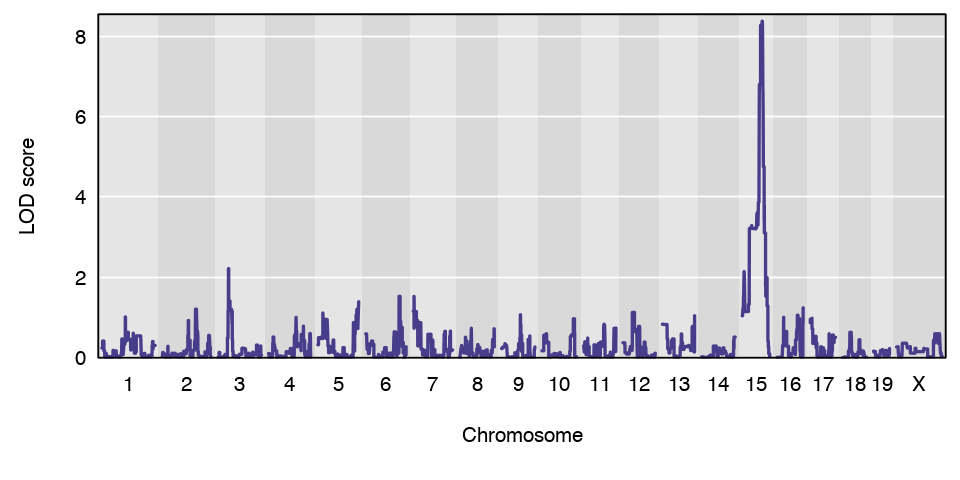

In [12]:
library(repr)
options(repr.plot.height=4, repr.plot.width=8)
par(mar=c(5.1, 4.1, 0.6, 0.6))
plot(out, pmap)

There's a clear QTL on chromosome 8. We can make a plot of just that chromosome with the argument `chr=15`.

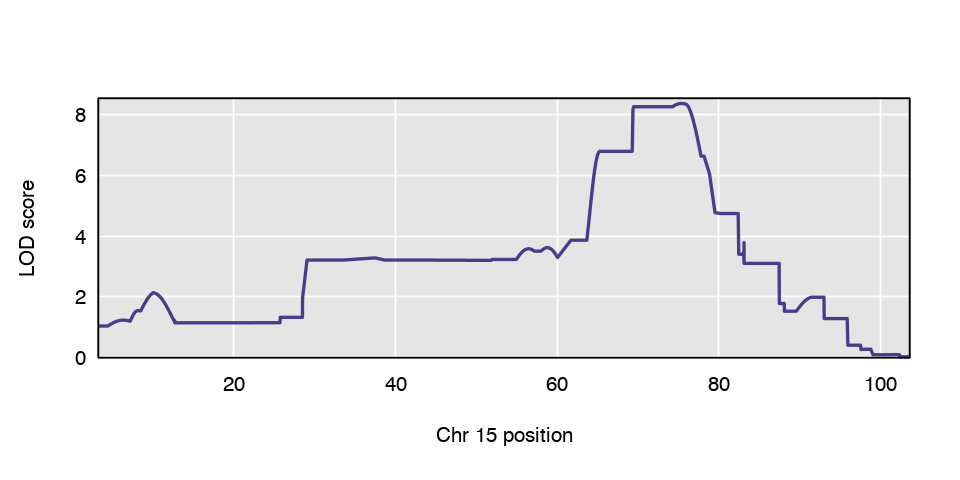

In [13]:
plot(out, pmap, chr=15)

Let's create a plot of the phenotype vs the genotype at the inferred QTL. We first need to identify the QTL location, which we can do using `max()`. We then use `maxmarg()` to get inferred genotypes at the inferred QTL.

In [14]:
mx <- max(out, pmap)
g_imp <- maxmarg(pr, pmap, chr=mx$chr, pos=mx$pos, return_char=TRUE)

We can use `plot_pxg()` to plot the phenotype as a function of QTL genotype. We use `swap_axes=TRUE` to have the phenotype on the x-axis and the genotype on the y-axis, rather than the other way around. Here we see that the BB and DD genotypes are completely separated, phenotypically. 

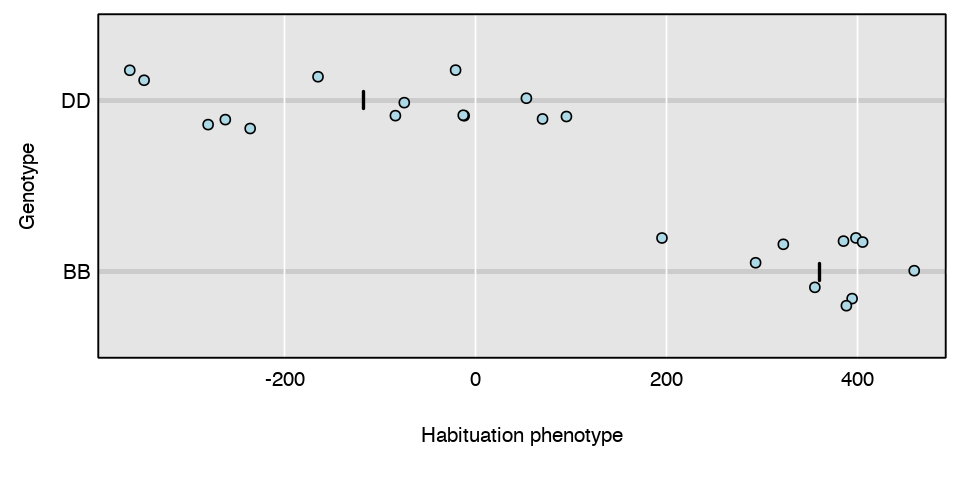

In [15]:
par(mar=c(5.1, 4.1, 0.6, 0.6))
plot_pxg(g_imp, pheno, swap_axes=TRUE, xlab="Habituation phenotype")

## Browse genome scan results with Genetics Genome Browser

The [Genetics Genome Browser](https://github.com/chfi/purescript-genome-browser) is a fast, lightweight, [purescript]-based genome browser developed for browsing GWAS or QTL analysis results. We'll use the R package [R/qtl2browse](https://github.com/rqtl/qtl2browse) to view our QTL mapping results in the GGB.

We first need to install the R/qtl2browse package, again from a private [CRAN](https://cran.r-project.org)-like repository.

```r
install.packages("qtl2browse", repos="http://rqtl.org/qtl2cran")
```

We then load the package and use its one function, `browse()`, which takes the `scan1()` output and corresponding physical map (in Mbp). This will open the Genetics Genome Browser in a separate tab in your web browser.

In [16]:
library(qtl2browse)
browse(out, pmap)